# Improt some packages

In [12]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
# import tensorflow_io as tfio
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
import tensorflow_addons as tfa
import os

import string
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import random
import time
import cv2
from keras.regularizers import l2

from pathlib import Path

from tqdm import tqdm

import re
from IPython import display
from keras.callbacks import ModelCheckpoint

BATCH_SIZE = 64

In [13]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

2 Physical GPUs, 1 Logical GPUs


# Load the dataset
* In this section, we load the dataset from given .npy file.
* We bind the image and it label, and batch the dataset. 

In [14]:
x_train = np.load('./x_train_cifar10_unlearn.npy')
y_train = np.load('./y_train_cifar10.npy')
x_val = np.load('./x_val_cifar10.npy')
y_val = np.load('./y_val_cifar10.npy')

y_train = np.argmax(y_train, axis=1)
y_val = np.argmax(y_val, axis=1)

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
batched_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)

val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
batched_val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)

In [15]:
# train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# batched_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)

# val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
# batched_val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)

# Show the image we load

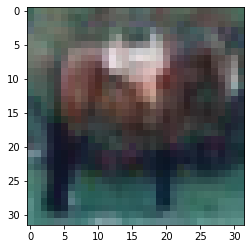

In [5]:
for data in batched_dataset.take(1):
    plt.imshow(data[0][3],cmap='gray')

# Preprocess layers
* In this part, we list some utlitity fuction and the data augmentation function.
* Grayscale : Useful to improve robustness but we use edge-map in the end because the effect is similar.  
* Power : Try to improve the high-frequency feature but not very useful.
* Self_Attention : Cannot improve the performance
* RGB2LAB : Cannot improve the performance
* Brightness : Slightly improve the performance
* Edge : We use sobel edge map to as final input.

In [23]:
tf.compat.v1.enable_eager_execution()
class Grayscale(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, x):
        return tf.image.rgb_to_grayscale(x)
    
class Power(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, x):
        return x**2
class Self_Attention(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.att = layers.Attention()
    def call(self, x):
#         print(x.shape)
        return self.att([x,x])
class RGB2LAB(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, x):
        return tfio.experimental.color.rgb_to_lab(x)
class Brightness(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, x):
        return tf.image.adjust_brightness(x, 0.4)
class Canny(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, x):
#         blurred = cv2.GaussianBlur(x.numpy(), (5, 5), 0)
#         canny = cv2.Canny(blurred, 30, 150)
        edge = tf.reshape(tf.image.sobel_edges(x), [BATCH_SIZE, 32, 32, 6])
        # edge = tf.reshape(tf.image.sobel_edges(x), [20, 32, 32, 6])
        edgeMap = edge**2
        edgeMap = tf.math.reduce_sum(edgeMap, axis=-1)
        edgeMap = tf.sqrt(edgeMap)
        edgeMap = tf.reshape(edgeMap, [BATCH_SIZE, 32, 32, 1])
        # edgeMap = tf.reshape(edgeMap, [20, 32, 32, 1])
#         dx, dy = tf.split(edge, num_or_size_splits=2, axis=3)
#         return dx
        return edgeMap
#         return tf.keras.layers.Concatenate(axis=3)([x, edgeMap])

This block implement the augmentation in our project. We used 4 different augmentations, which are Random Flip, Random Translation, Random Zoom and sobel edge detection.

In [24]:
preprocess = Sequential([
     tf.keras.layers.experimental.preprocessing.Normalization(),
    # tf.keras.layers.GaussianNoise(stddev=0.2),
    layers.experimental.preprocessing.RandomTranslation(0.1, 0.1),
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomZoom(height_factor=0.05, width_factor=0.05),
#     Grayscale(),
    Canny(),
    ])

# Model
* Use Resnet50v2 as feature extractor since a complex model tends to overfit.(We tried efficientnet, inceptionnetv3, and other deeper models) 

In [18]:
batched_dataset = batched_dataset.map(lambda x, y: (preprocess(x), y))
batched_val_dataset = batched_val_dataset.map(lambda x, y: (preprocess(x), y))
model = Sequential([
 tf.keras.applications.resnet_v2.ResNet50V2(
    input_shape=(32, 32, 1),
    include_top=False,
    weights = None,
    pooling=None,
),
    layers.Flatten(),
    # layers.Dense(1024, activation='relu', kernel_regularizer=l2(0.01)),
    layers.Dense(512, activation='relu', kernel_regularizer=l2(0.01)),
    layers.Dense(256, activation='relu'),
    layers.Dense(10)
])

# model.summary()

# Loss and optimizer
* We use SparseCategoricalCrossentropy as loss function
* We tried to use scheduler to improve optimizer but we finnally adjust the hyperparameters.

In [9]:
loss_fn = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=34*1000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)
optimizer = tf.optimizers.Adam(beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-8)
# optimizer = get_optimizer()
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['acc'])

# Training

In [10]:
filepath="./improve_weight/weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1,
    save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit(x=batched_dataset, validation_data=batched_val_dataset, epochs=250, callbacks=callbacks_list)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Epoch 1/250
625/625 [==============================] - 42s 60ms/step - loss: 3.9047 - acc: 0.2288 - val_loss: 2.6791 - val_acc: 0.2935

Epoch 00001: val_acc improved from -inf to 0.29347, saving model to ./improve_weight/weights-improvement-01-0.29.hdf5
Epoch 2/250
625/625 [==============================] - 36s 58ms/step - loss: 1.7075 - acc: 0.3997 - val_loss: 1.8619 - val_acc: 0.4066

Epoch 00002: val_acc improved from 0.29347 to 0.40655, saving model to ./improve_weight/weights-improvement-02-0.41.hdf5
Epoch 3/250
625/625 [==============================] - 36s 58ms/step - loss: 1.4422 - acc: 0.5027 - val_loss: 2.0038 - val_acc: 0.4141

Epoch 00003: val_acc improved from 0.40655 to 0.41406, saving model to ./improve_weight/weights-improvement-03-0.41.hdf5
Epoch 4/250
625/625 [==============================] - 36s 58ms/step - loss: 1.3091 - acc: 0.5542 - val_loss: 1.3426 - val_acc: 0.5501

Epoch 00004: val_acc improved from 0.41406 to 0.55008, saving model to ./improve_weight/weights-

In [ ]:
# checkpoint_path = "/home/jinghao/miniconda3/2021_Deep_Learning/DL_comp4/best_model.hdf5"
# checkpoint_dir = os.path.dirname(checkpoint_path)

In [ ]:
# os.listdir(checkpoint_dir)

In [ ]:
# # model.save("./edge_eff24")
# from keras.models import load_model
# model = load_model('best_model.hdf5')

# Saving and loading models

In [20]:
model.load_weights("/home/jinghao/miniconda3/2021_Deep_Learning/DL_comp4/improve_weight/weights-improvement-172-0.73.hdf5")

# Testing

In [25]:
import csv

header = ['id', 'label']
x_test = np.load('./x_test_cifar10.npy')
# x_test = np.load('./dataset_imgnet/x_test_imagenet.npy')
print(x_test.shape)
# x_test = tf.image.rgb_to_grayscale(x_test)
print(x_test.shape)
test_dataset = tf.data.Dataset.from_tensor_slices(x_test)
test_dataset2 = test_dataset.batch(20, drop_remainder=False)
test_dataset2 = test_dataset2.map(lambda x: (preprocess(x)))
res = model.predict(test_dataset2)
res = np.argmax(res, axis=1)
print(res.shape)
with open('res_ci5_72.csv', 'w', encoding='UTF8') as f:
    writer = csv.writer(f)
    writer.writerow(header)
    
    for i, y in enumerate(res):
        writer.writerow([i, y])

(10000, 32, 32, 3)
(10000, 32, 32, 3)
(10000,)


In [ ]:
print(res.shape)

# Describe what you have done to improve your training accuracy in detail.

* We tried different models as input and found that simpler model is more stable to unlearnable datasets.
* We tried to apply different augmentation and found that such strong augmentations like edge-detection is very useful to improve validation accuracy.
* We also used SAM(https://github.com/sayakpaul/Sharpness-Aware-Minimization-TensorFlow) to find the better converge point. SAM attempts to simultaneously minimize loss value as well as loss curvature thereby seeking parameters in neighborhoods having uniformly low loss value. However, it can't help us get the better result.